# Data Intersection

In this first part we'll explore the dataset and extract a white list of only the "case ID" present in all data.
The variable "SAVE_FILE" specify if we want to save the white list in a file.

In [1]:
WL_SAVE_FILE = False
WL_OUTPUT_FOLDER = "."

LIST_FILE_PATH_JSON = [
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/CopyNumber.json",
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/GeneExpression.json",
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/Methylation.json",
    "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/OverallSurvival.json"
]

In [2]:
import json

In [3]:
list_list_case_id = []

# Iterate over each file.
for file_name in LIST_FILE_PATH_JSON:
    list_case_id = []
    with open(file_name, 'r') as file:
        file_parsed = json.load(file)
        # Iterate over each case.
        for case in file_parsed:
            case_id = case["cases"][0]["case_id"]
            if not case_id in list_case_id:
                list_case_id.append(case_id)
    print(f"{file_name}: {len(list_case_id)}")
    list_list_case_id.append(list_case_id)


# Find intersection of all the case id.
intersection_of_case_id = set.intersection(*map(set,list_list_case_id))

if WL_SAVE_FILE:
    with open(WL_OUTPUT_FOLDER + "/" + 'case_id_intersection_white_list.json', 'w', encoding='utf-8') as f:
        json.dump(list(intersection_of_case_id), f, ensure_ascii=False, indent=4)

print(f"Total intersection: {len(intersection_of_case_id)}")



/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/CopyNumber.json: 567
/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/GeneExpression.json: 416
/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/Methylation.json: 569
/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/OverallSurvival.json: 580
Total intersection: 407


# Data Analisys and subset division

In this second part we'll identify, based on the previous white list, which case have an attribute "days_to_death" or "days_to_last_followup", which define if the user died or was seen alive until the last followup.
Then after an analisys of the two subset we'll try to balance them.

In [4]:
A_SAVE_FILE = False
A_OUTPUT_FOLDER = "."

OS_FOLDER_PATH = "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/OverallSurvival"
FILE_PATH_DICT = {
    'os': "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/OverallSurvival.json",
    'gene': "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/GeneExpression.json",
    'methylation': "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/Methylation.json",
    'copy_number': "/work/h2020deciderficarra_shared/TCGA/OV/project_n16_data/JSON/CopyNumber.json"
}

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
from pathlib import Path
import re
import xml.etree.ElementTree as ET
import seaborn as sns
import numpy as np
import json

/homes/dlupo/.local/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Get file name corresponding to white list "case ID"

In [6]:
list_file_name_white_list = []

save_file_to_id_relation = {}

with open(FILE_PATH_DICT['os'], 'r') as file:
    file_parsed = json.load(file)
    for case in file_parsed:
        case_id = case["cases"][0]["case_id"]
        if case_id in intersection_of_case_id:
            save_file_to_id_relation[case['file_name']] = case_id
            list_file_name_white_list.append(case['file_name'])

### Read file in white list

In [7]:
dirs = [x for x in Path(OS_FOLDER_PATH).iterdir() if x.is_dir()]

dead_list = []

dead_output_dict = {}
#   {*case_id*: {os:int, files={type:str, name:str}}}

dead_alive_dict = {}

r = re.compile('.*.xml')

for dir in dirs:
    file_name_list = [x for x in dir.iterdir() if r.match(str(x))]

    if len(file_name_list) == 1:
        file_name = file_name_list[0]
        relative_file_name = str(file_name).split("/")[-1]
        if relative_file_name in list_file_name_white_list:
            # We found a file present in the white list.
            tree = ET.parse(file_name)
            root = tree.getroot()
            namespaces = {
                'admin': 'http://tcga.nci/bcr/xml/administration/2.7',
                'ov': 'http://tcga.nci/bcr/xml/clinical/ov/2.7',
                'clin_shared': "http://tcga.nci/bcr/xml/clinical/shared/2.7"
            }
            Days_to_death = root.findall('.//clin_shared:days_to_death',namespaces)[0].text
            Days_to_last_followup = root.findall('.//clin_shared:days_to_last_followup',namespaces)[0].text

            case_id = save_file_to_id_relation[relative_file_name]
            if not Days_to_death == None:                   
                # Dead.
                dead_list.append(Days_to_death)
                dead_output_dict[case_id] = {'os': int(Days_to_death), 'files':{}}
                dead_alive_dict[case_id] = {'os': int(Days_to_death), 'os_status': '1:DECEASED', 'files':{}}
            elif not Days_to_last_followup == None:
                # Alive.
                dead_alive_dict[case_id] = {'os': int(Days_to_last_followup), 'os_status': '0:LIVING', 'files':{}}
    else:
        raise Exception("Multiple \'xml\' file in the same folder.")

In [8]:
len(dead_alive_dict)

405

### Get all the file name relative to the case_id

In [9]:
for k in FILE_PATH_DICT.keys():
    with open(FILE_PATH_DICT[k], 'r') as file:
        file_parsed = json.load(file)
        for case in file_parsed:
            case_id = case["cases"][0]["case_id"]
            if case_id in dead_alive_dict.keys():
                dead_alive_dict[case_id]['files'][k] = case['file_name']

In [10]:
import csv
# Salva un CSV con case_id, os, os_status dal dizionario dead_alive_dict
with open('case_id_os_status_ALL.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, quoting=csv.QUOTE_ALL)
    writer.writerow(['case_id', 'OS', 'OS_STATUS'])
    for case_id, info in dead_alive_dict.items():
        writer.writerow([(case_id), info.get('os', ''), info.get('os_status', '')])

### Save the data structure

In [ ]:
with open(A_OUTPUT_FOLDER + "/" + 'case_id_and_structure_aALL.json', 'w', encoding='utf-8') as f:
    json.dump(dead_alive_dict, f, ensure_ascii=False, indent=4)

In [10]:
dead = pd.Series([int(d) for d in dead_list])

In [11]:
print(len(dead_output_dict.keys()))

226


### Graph the subset

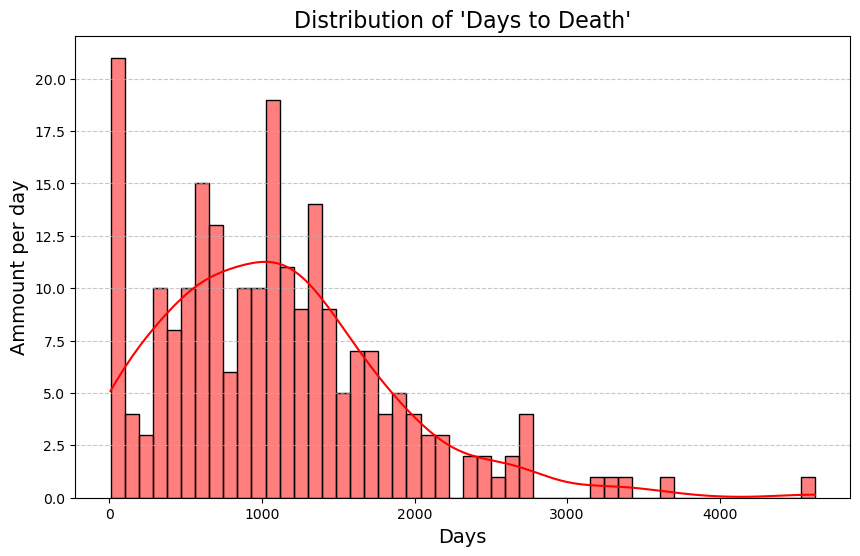

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(dead, bins=50, kde=True, color="red")
plt.title("Distribution of \'Days to Death\'", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Ammount per day", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
mean_value = np.mean(dead)
median_value = np.median(dead)
std_deviation = np.std(dead)

center_curve = int(median_value)
 
print(f"Mean: {mean_value:.2f}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_deviation:.2f}")

Mean: 1092.93
Median: 1032.5
Standard Deviation: 753.95


In [16]:
# Get all file name:
file_name = [dead_output_dict[k]['files']['os'] for k in dead_output_dict.keys()]

In [4]:
import numpy as np
a = [0.6070706844329834, 0.5747475028038025, 0.5242424011230469, 0.5525252819061279, 0.5202020406723022, 0.6205852627754211, 0.6205852627754211, 0.59375, 0.7114025950431824, 0.6239919066429138]
print(np.mean(a))

0.5949102938175201
